# Numerical Computation with libCEED and PETSc

Numerical simulations based upon PDEs use several concepts of numerical computation.
These simulations are used in many applications, such as fluid dynamics and solid mechanics.

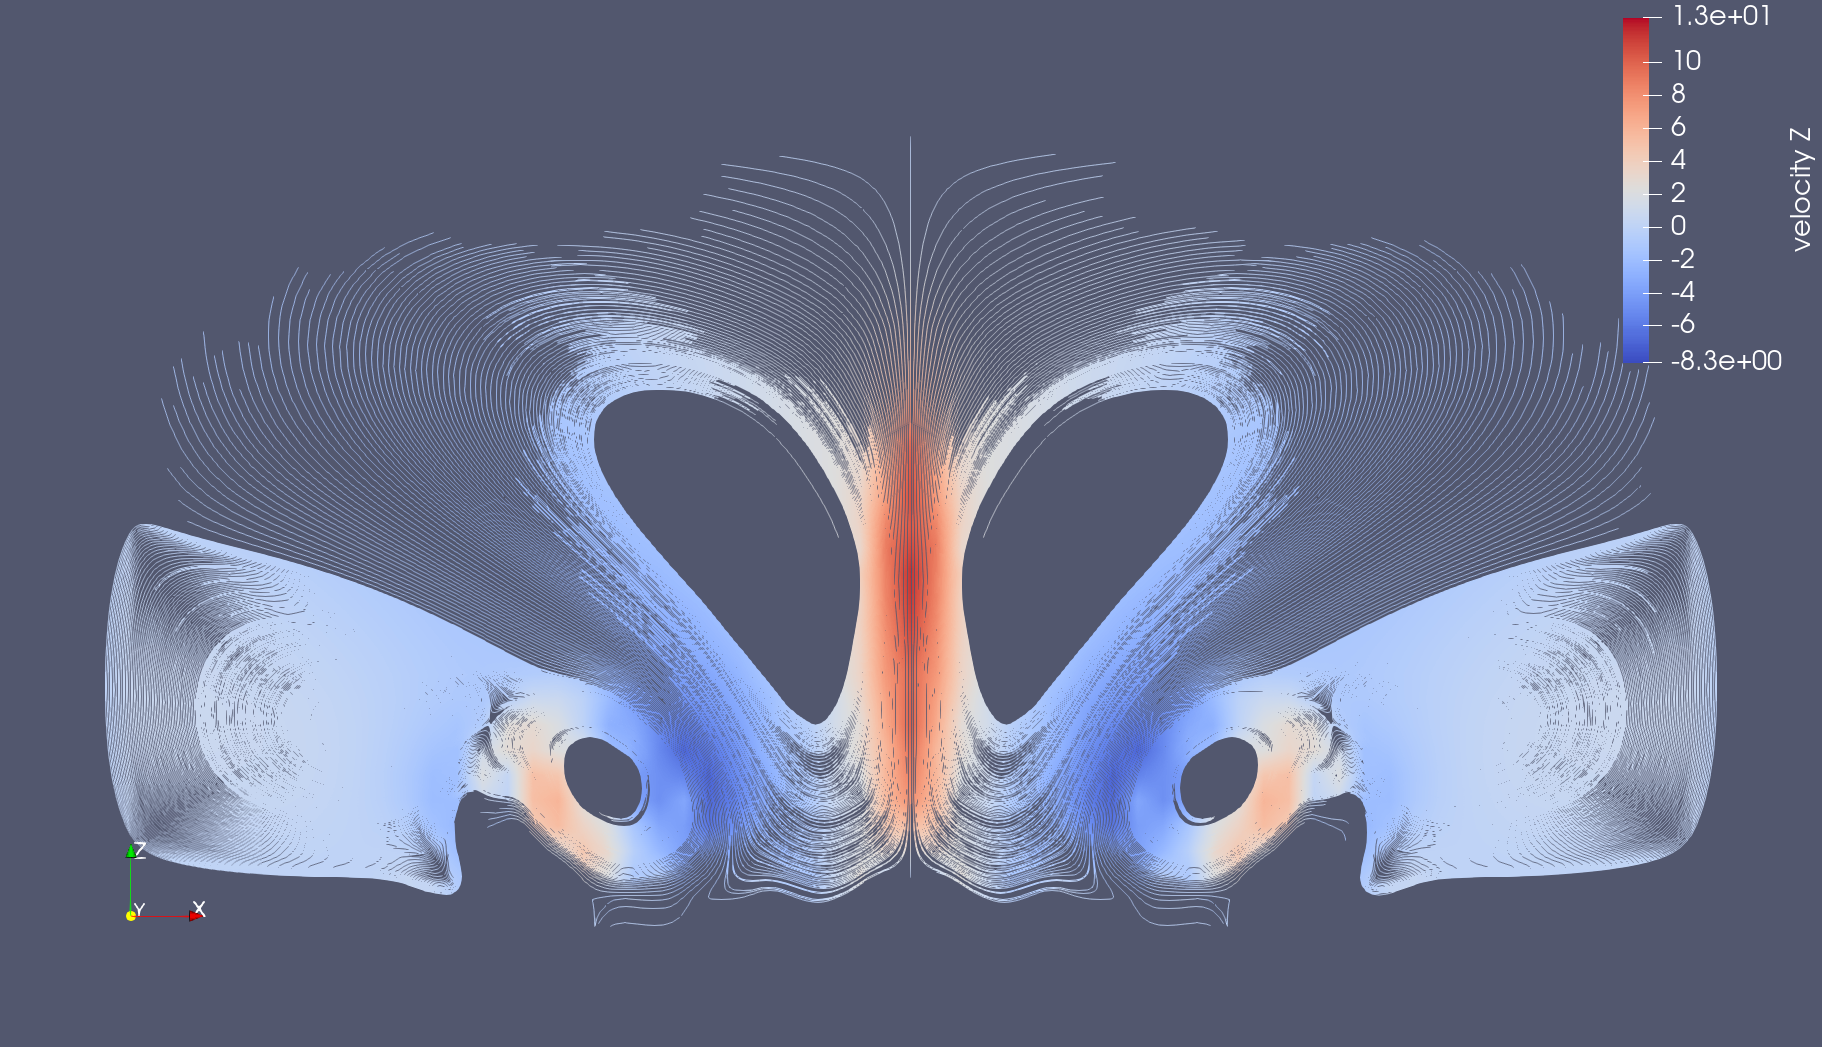

Vortices from falling cold air bubble (See [HONEE](https://gitlab.com/phypid/honee))

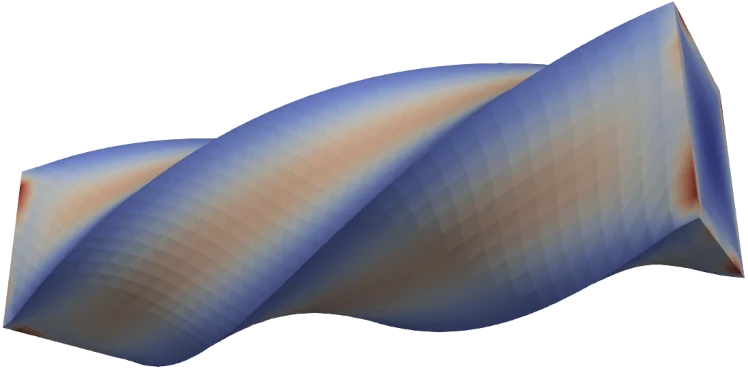

Beam deforming under twisting force (See [Ratel](https://gitlab.com/micromorph/ratel))

[libCEED](https://www.github.com/CEED/libCEED) and [PETSc](https://gitlab.com/petsc/petsc) can be used together for physics based numerical simulations of solutions to PDEs.

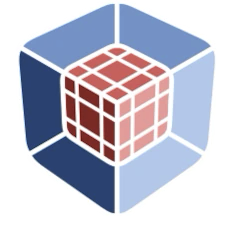 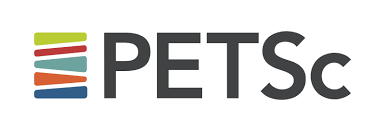

## Illustrative example

PDE based simulations is a huge topic.
We will highlight many key areas of numerical computation in PDE based simulations via a specific example - [Poisson's equation](https://en.wikipedia.org/wiki/Poisson%27s_equation)

$$ - \nabla^2 u = f $$

This is a generalization of [Laplace's equation](https://en.wikipedia.org/wiki/Laplace%27s_equation), and both PDEs have several applications, such as electrostatics, fluid dynamics, thermodynamics, and more.

## Massaging the math

We'll make a few changes to the math equation we're solving before talking about numerical computation.

1) First, I will convert this problem into something slightly easier to solve.
(There is plenty that we could say about [weak forms](https://en.wikipedia.org/wiki/Weak_formulation) that I will omit here, but trust me that this is an easier math problem to solve.)

$$ - \int_\Omega v \nabla^2 u \, dV = \int_\Omega v f \, dV $$

Simplification with [integration by parts](https://en.wikipedia.org/wiki/Integration_by_parts) and [Green's identity](https://en.wikipedia.org/wiki/Green%27s_identities) yields

$$ \int_\Omega \nabla v \cdot \nabla u \, dV - \int_{\partial \Omega} v \nabla u \cdot \hat{n} \, dS  = \int_\Omega v f \, dV $$

2) Second, I will assume that $u$ and $v$ have piecewise polynomial solutions.
(Piecewise continuous but with no continuity in the derivatives, so not splines.)

Together, these two changes mean I am using a [finite element method](https://en.wikipedia.org/wiki/Finite_element_method).

## Computational domain

The next thing we need to do is [discretize](https://en.wikipedia.org/wiki/Discretization) the problem.
This is to say, we need to choose a series of points $x$ where we will find our piecewise polynomial solution $u$.

This will turn our continuous problem into a system of equations we can solve with various computational techniques.

While selecting our discretization, we should keep in mind the properties of [numerical integration](https://en.wikipedia.org/wiki/Numerical_integration) so we can select good solution points (nodes) as well as suitable quadrature points and weights.
We'll also consider computational efficiency (more on this below!) as we select the solution nodes and quadrature scheme.

Given our continuous problem

$$ \int_\Omega \nabla v \cdot \nabla u \, dV - \int_{\partial \Omega} v \nabla u \cdot \hat{n} \, dS  = \int_\Omega v f \, dV $$

we will solve the discrete analogue

$$ F \left( x \right) - R  = 0 $$

where $F \left( x \right)$ is the discretization of $\int_\Omega \nabla v \cdot \nabla u \, dV$ and $R$ is the discretization of $\int_\Omega v f \, dV$, both with appropriate handling of the boundary conditions.
(I am glossing over boundary conditions here, but it is a very important topic.)

Numerical computation topics: piecewise interpolation, numerical integration

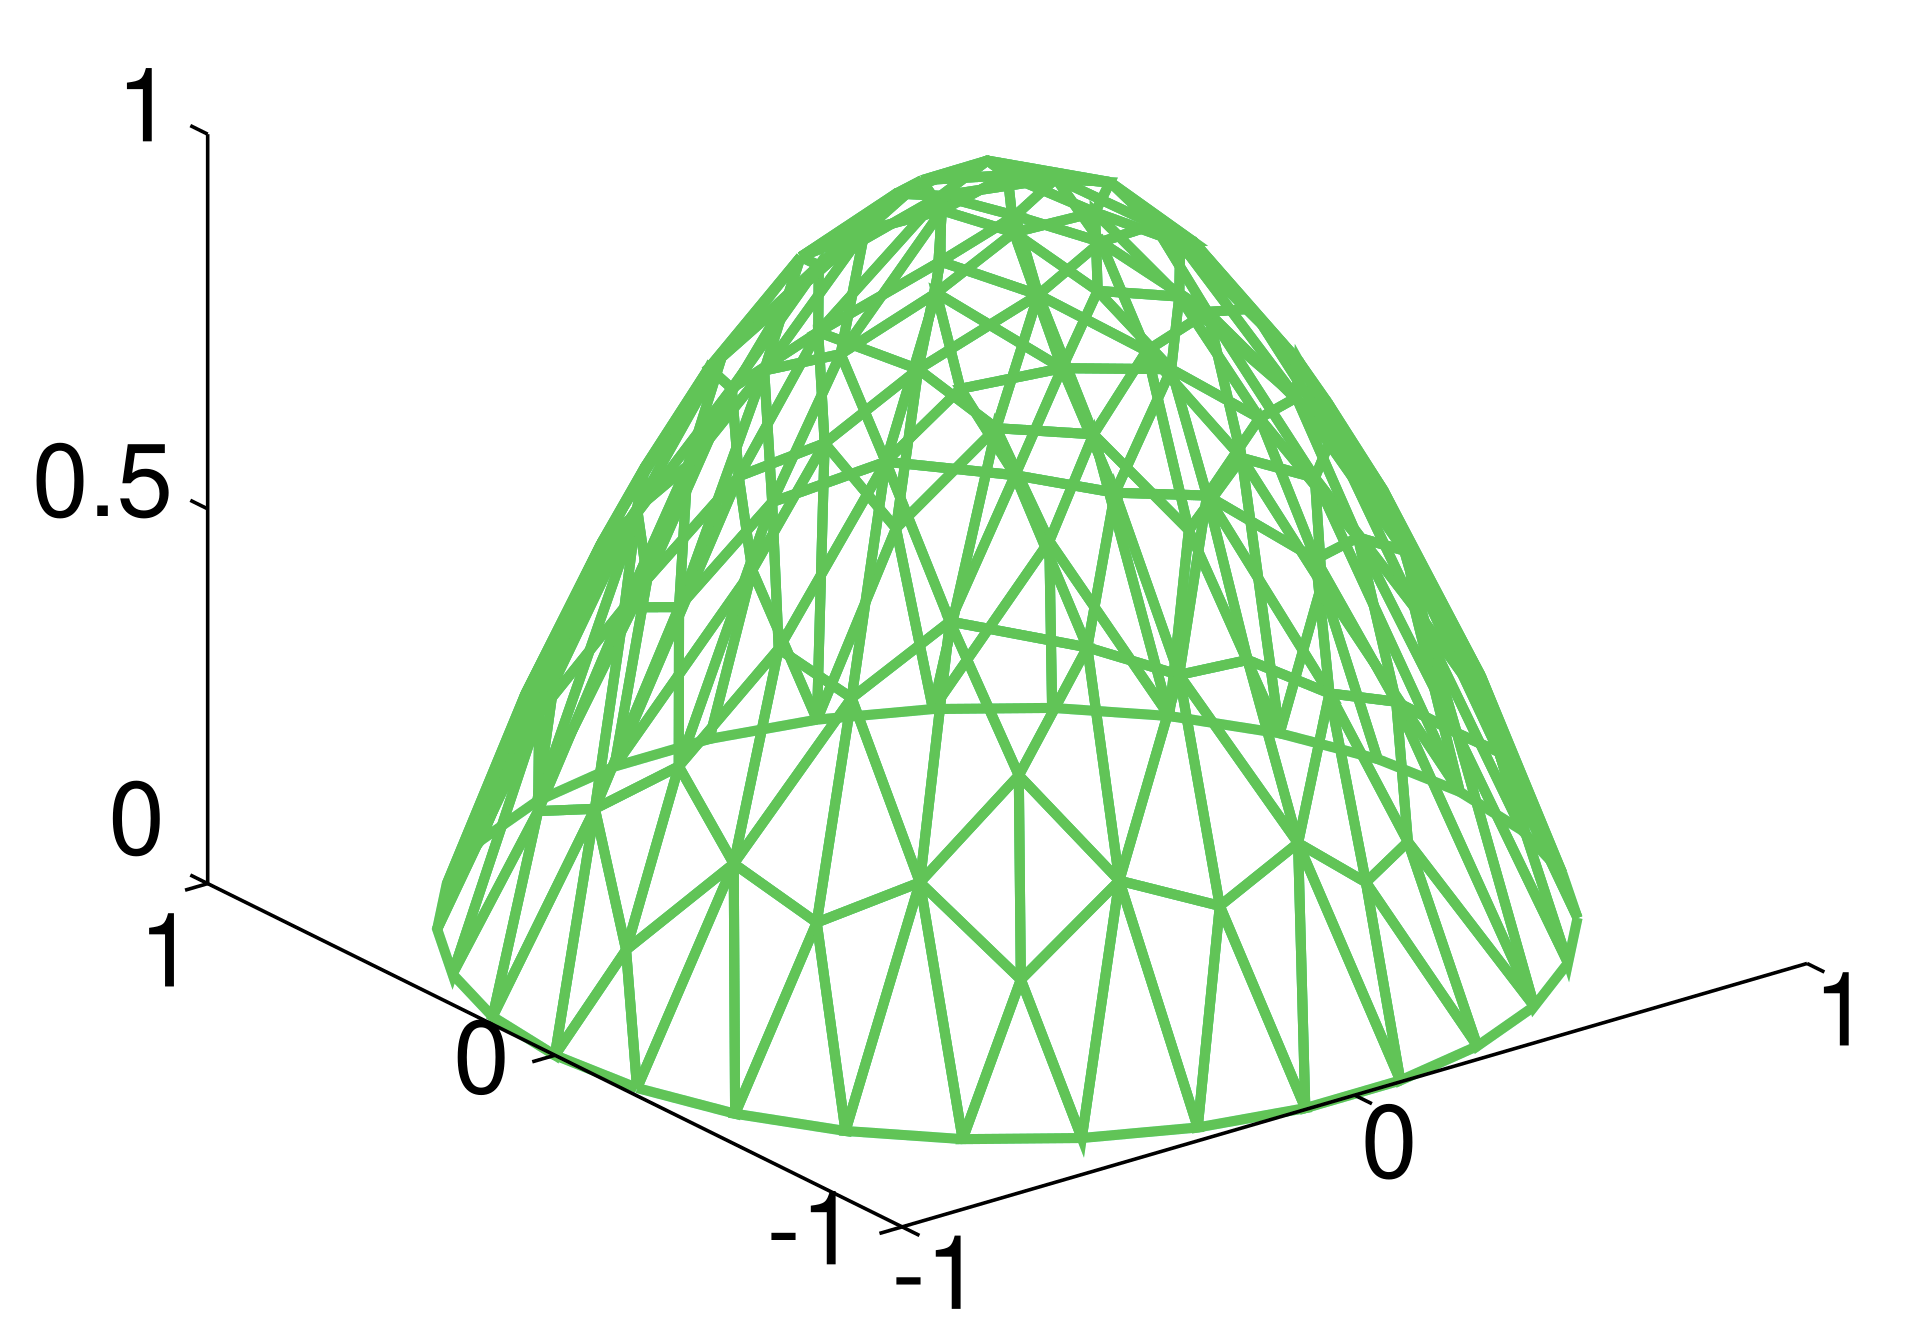

## Non-linear problem

This is a non-linear system of equations, so we need some sort of non-linear rootfinding technique.
We want to find values at the points in our solution domain such that

$$ F \left( x \right) - R = 0$$

We can use a non-linear rootfinding technique, such as Newton (with a line search perhaps?).

Numerical computation topic: rootfinding

## PETSc

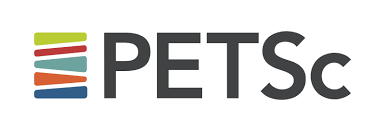

This is where PETSc comes into the picture.

PETSc allows us to solve non-linear and linear systems of equations.


Note that PETSc has the ability to do 'timestepping', which adds an additional layer to the conceptual framework here.
These timesteppers would be used for solving a PDE with time varying terms, such as time varying boundary conditions, forcing ($R \left( t \right)$), or coefficients ($F \left( x, t \right)$).
We will omit timestepping in our discussion here.

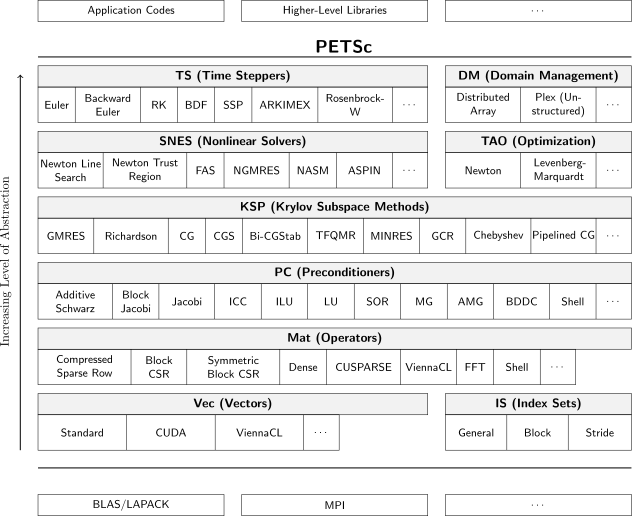

## Newton-Krylov

PETSc has many non-linear solvers to pick, but we will focus on Newton.
Our approach here will be [Newton-Krylov method](https://en.wikipedia.org/wiki/Newton%E2%80%93Krylov_method).

We will solve the equation

$$ F \left( x_k \right) - R + J \left( x_k \right) \left( x_k - x_{k + 1} \right) = 0 $$

to produce Newton steps that look like

$$ x_{k + 1} = x_k - J^{-1} \left( x_k \right) \left( F \left( x_k \right) - R \right) $$

Where $J \left( x_k \right)$ is the [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant), which is the matrix formed from the first order partial derivatives of our $F \left( x \right)$.

## Linear problem

We need to solve the linear system of equations

$$ J \left( x_k \right) \Delta x = - F \left( x_k \right) + R $$

for the Newton step $\Delta x$ in an efficient manner.
As $x_k$ is fixed, we can say this more compactly and clearly as

$$ J_k \Delta x = F_k $$

We will use one of PETSc's [Krylov subspace](https://en.wikipedia.org/wiki/Krylov_subspace) methods.

Numerical computing topic: linear algebra (systems of equations)

## Computational efficiency

We want to use Krylov methods to solve this linear problem for two very good reasons.

1) The system of equations will be very *sparse* due to the piecewise solution $u$, but a 'direct solver' such as QR factorization or the SVD produces *dense* matrices that rapidly fill up our memory.

2) Krylov methods are an example of [matrix free methods](https://en.wikipedia.org/wiki/Matrix-free_methods), which allow us to better match our implementation to modern hardware constraints.

## Modern hardware

Modern computing hardware (CPUs and GPUs both) can do FLOPs faster than they can move memory.
Therefore, we want to use as little memory as possible when applying the matrix $J_k$ inside of the Krylov method.

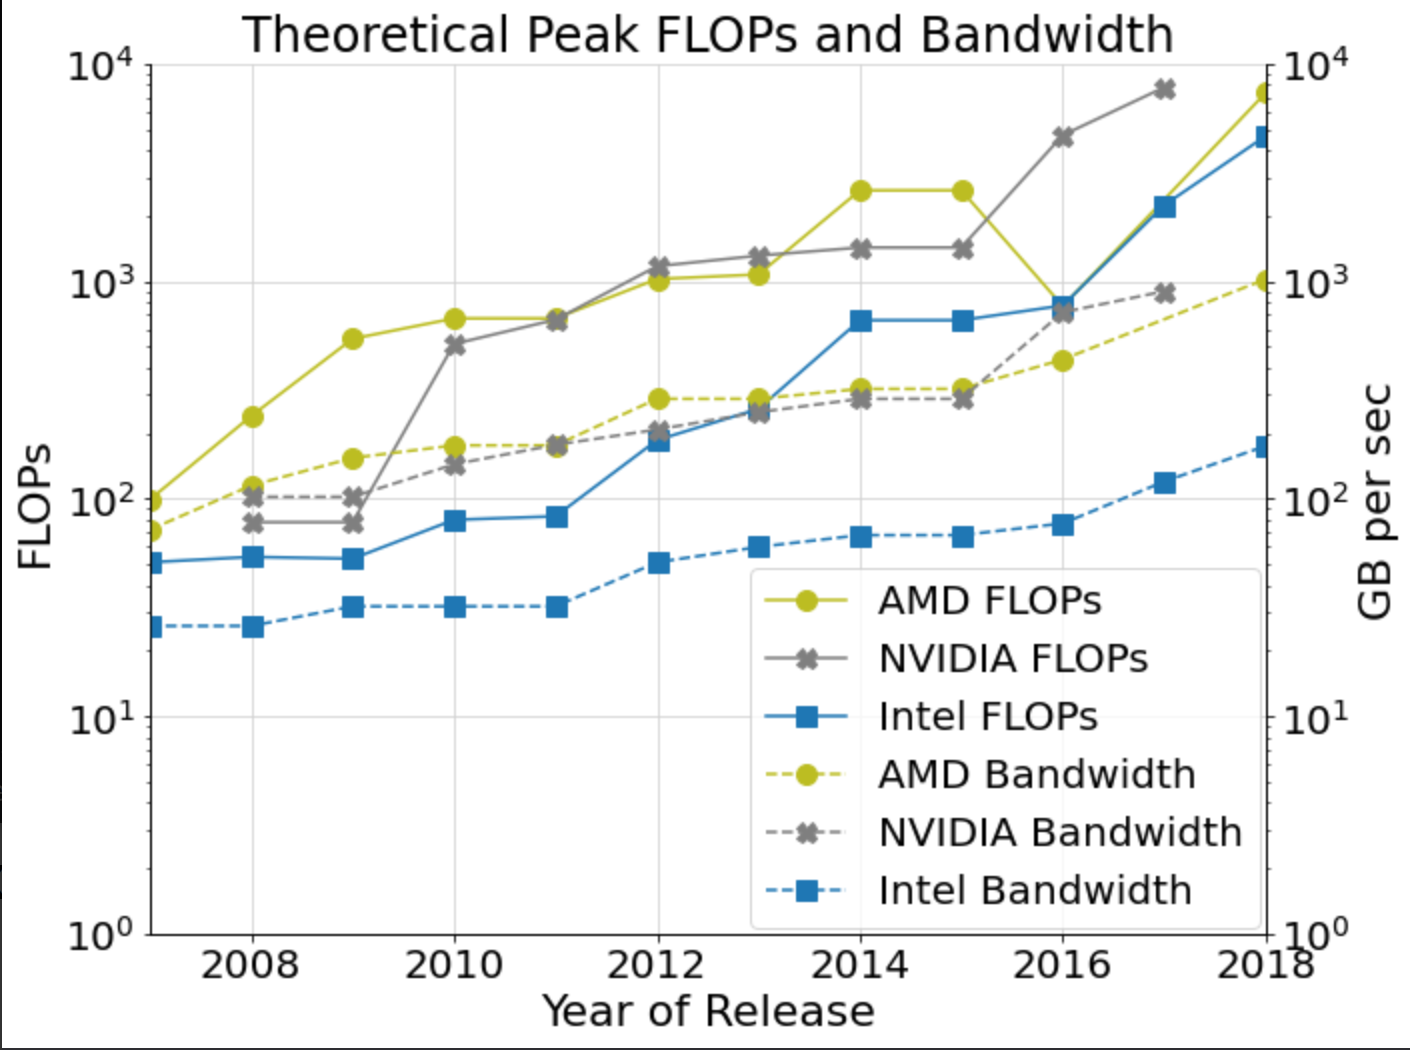

Matrix-free implementations of these linear and non-linear operators provide a ratio of required memory and FLOPs that is closer to the specifications of modern hardware.

Note that matrix-free implementations can result in fewer total FLOPs required on meshes where the finite elements (each 'piece' of the piecewise polynomial solution) have a [tensor product](https://en.wikipedia.org/wiki/Tensor_product) structure.

The chart below shows the approximate cost, in terms of FLOPs and bytes, for the operators to solve the [screened Poisson equation](https://en.wikipedia.org/wiki/Screened_Poisson_equation) with sparse and matrix-free implementations, based upon the degree of the polynomial basis functions.

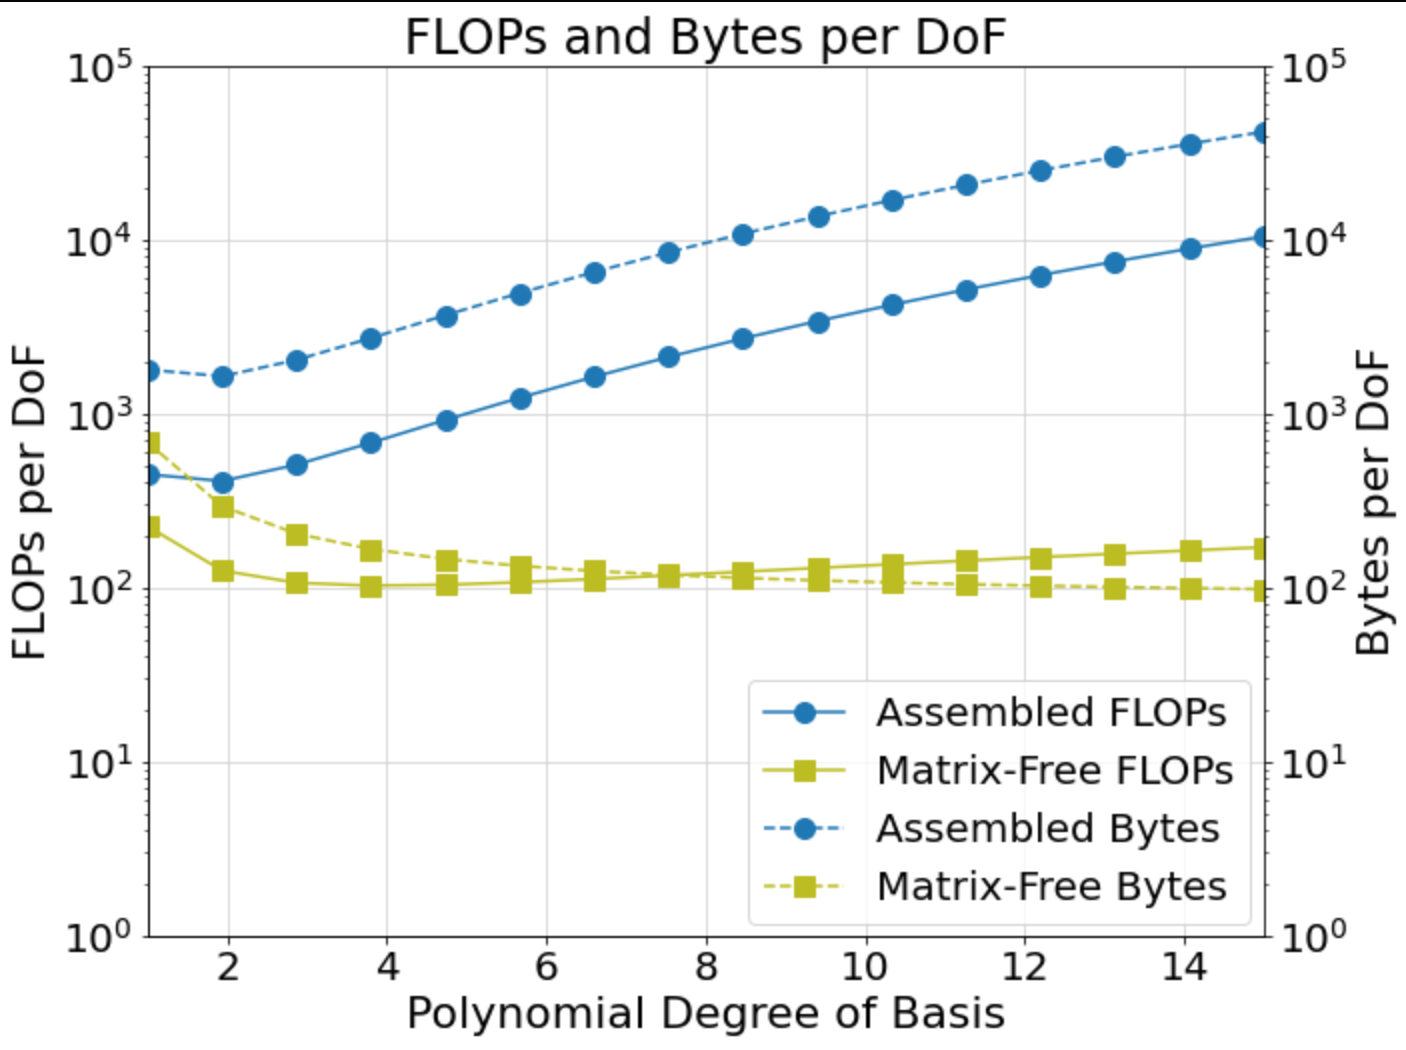

## libCEED

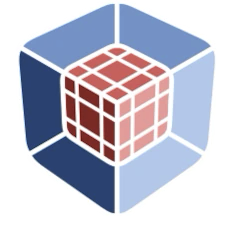

Finally, this is where libCEED comes into the picture.

libCEED decomposes the matrix $J_k$ (and the non-linear system $F \left( x \right)$ too!) into mathematical pieces that are easier to apply efficiently on modern computing hardware.

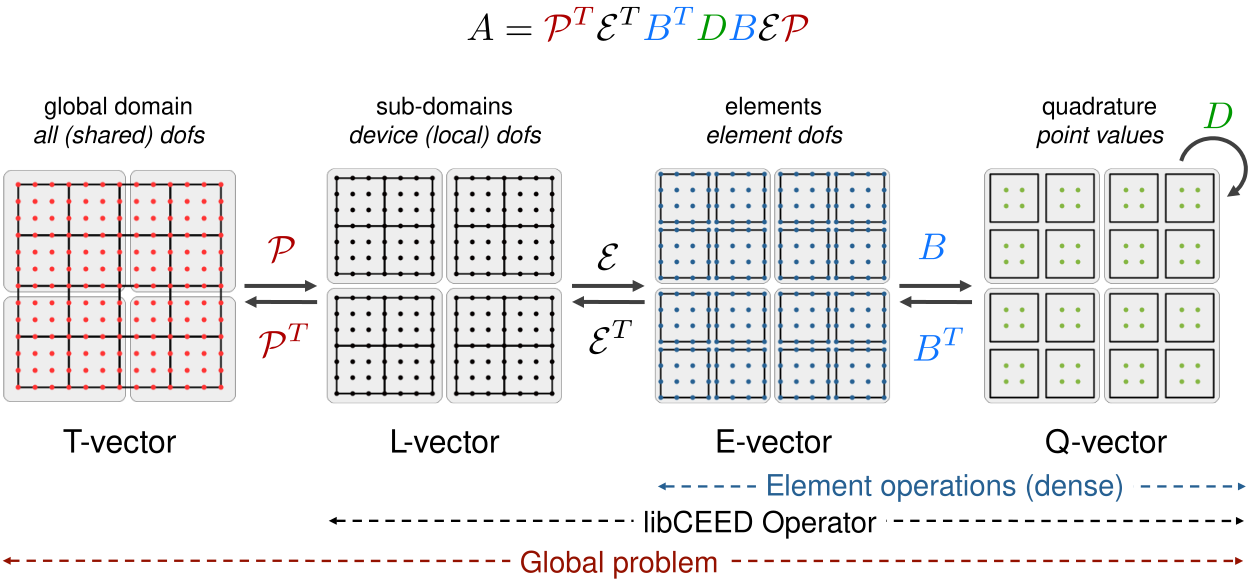

libCEED efficiently applies the matrix-vector product $A x$ or the non-linear function evaluation $F \left( x \right)$ by decomposing operators $A$ and $F$ into the following parts:

1) $\mathcal{E}$ - the *element restriction* which retrieves the entries of $x$ (nodes) for a specific finite element.

2) $B$ - the *finite element basis* which provides values from the interpolating polynomial (or its derivatives) at the quadrature points (integration points) of the finite element.

3) $D$ - the *quadrature point function* which provides the code to execute the math of the PDE at the quadrature points.
This represents the math inside of the integrals of the weak form above.

4) $B^T$ - the *finite element basis* applied in transpose, representing the [test functions](https://en.wikipedia.org/wiki/Bump_function) for the finite element basis.

5) $\mathcal{E}^T$  - the *element restriction* applied in transpose, to sum the effect of $A x$ or $F \left( x \right)$ into the vector holding the result.

The operations $P$ and $P^T$ require parallel communication and are handled by PETSc.

## Performance portability

This approach also provides [performance portability](https://en.wikipedia.org/wiki/Performance_portability), which means that the same code can be used for a variety of different hardware.

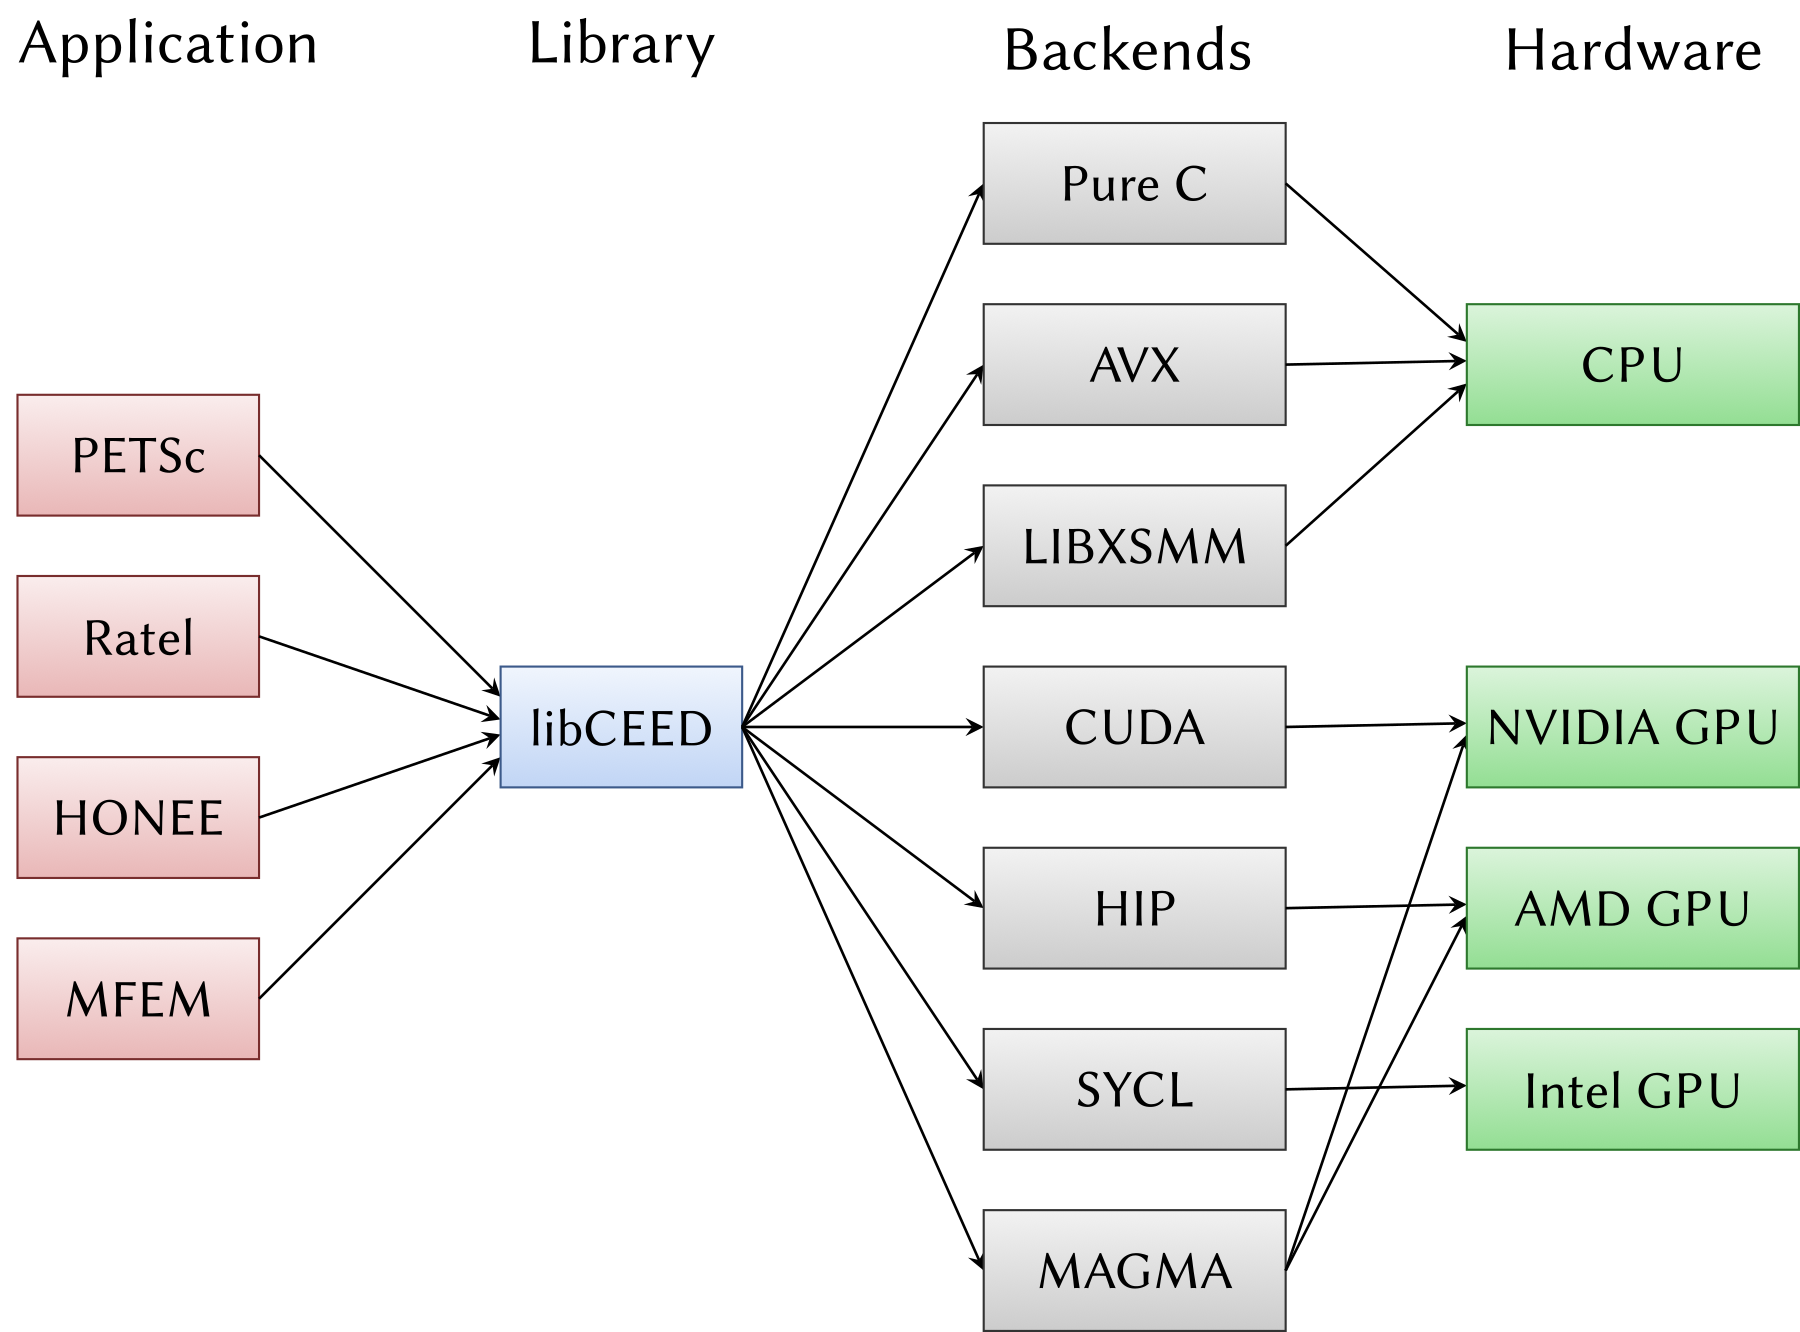

## Recap

Pulling it all together, a scientific simulation relies upon several areas of numerical computation.

* Non-linear solvers - A physics based PDE will have a non-linear equation to solve

* Linear solvers - The non-linear solver will involve linear solves with the Jacobian matrix

* Discretization - The choice of points to solve the PDE at and how to fit a curve to those points

* Quadrature - Weak forms (and other pieces) require numerical integration

* Differentiation - Evaluating the Jacobian can be done via [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)

* Performance - Hardware informs mathematical representation and software implementation

## Projects with libCEED

There are several ways to make projects with libCEED.
We have bindings in several languages, including

* [C/C++](https://libceed.org/en/latest/api)
* Fortran (same API as for C/C++, but with minor differences)
* [Julia](https://ceed.exascaleproject.org/libCEED-julia-docs)
* [Python](https://libceed.org/en/latest/ffi)
* [Rust](https://docs.rs/libceed)

### Standard examples

There are three standard examples we use to outline the interface concepts.
These examples are based upon a single application of the operator, so computing the matrix-vector product $A u$.

1) `ex1-volume` - compute the volume of a region by computing $\int_\Omega v u \, dV$, where $u \left( x \right) = 1$.
In other words, this example applies the mass matrix to a vector of all `1`s.

2) `ex2-surface` - compute the surface area of a region by computing $\int_{\partial \Omega} 1 \, dS = \int_\Omega \nabla v \cdot \nabla u \, dV$ (Calc III identities!) ,where $u \left( x \right) = x_0 + x_1 + x_2$.
In other words, this example applies the diffusion operator to a vector whose values represent a linear function in $x, y, z$.

3) `ex3-volume` - compute the volume of a region by computing $\int_\Omega \left( u + \nabla^2 u \right) \, dV$, where $u \left( x \right) = 1$.
In other words, this example applies the mass matrix and diffusion operator to a vector of all `1`s.

Currently we have these examples for C/C++, Python, and Rust, but not for Fortran and Julia.

### Bakeoff examples

The [bakeoff problems](https://ceed.exascaleproject.org/bps/) use similar operators to the three given above, but they solve the linear system of equations $A u = f$.
These examples use linear solvers from [deal.II](https://dealii.org), [MFEM](https://mfem.org), [Nek5000](https://nek5000.mcs.anl.gov/), or [PETSc](https://petsc.org).

These examples are all written in C/C++.
The different packages have different levels of support for other languages.
For example, PETSc has strong C/C++, Fortran, and Python support, with incomplete Julia and Rust support.

It would be beneficial to have some of these bakeoff problems available in languages other than C/C++.

It could be beneficial to see these bakeoff problems modified to use both mass and diffusion operators, like `ex3-volume` above.
The implementation using PETSc has been modified in this way.

### Mini-application examples

We also have a fluid-dynamics mini-application (became the basis for [HONEE](https://honee.phypid.org) and solid-mechanics mini-application (became the basis for [Ratel](https://ratel.micromorph.org)).
These mini-applications are written with PETSc and libCEED.

Adding features to these mini-applications can be rather involved, and creating new mini-applications takes a significant amount of work.